In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import json
import matplotlib.pyplot as plt
import numpy as np
import string, random
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, Input, Model



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#drive.mount("/content/drive/")

In [3]:
datasetName = 'colorectal_histology'

# download the dataset
dataset, info = tfds.load(datasetName, split=f'train', as_supervised=True,with_info=True, shuffle_files=True)
dataset = dataset.shuffle(buffer_size=5000,reshuffle_each_iteration = False)
#dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))


print(f'dataset type {type(dataset)} with {len(dataset)} images')
print(info.supervised_keys)
print(info.features.items())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteFLVYUW/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
dataset type <class 'tensorflow.python.data.ops.shuffle_op._ShuffleDataset'> with 5000 images
('image', 'label')
dict_items([('image', Image(shape=(150, 150, 3), dtype=uint8)), ('label', ClassLabel(shape=(), dtype=int64, num_classes=8)), ('filename', Text(shape=(), dtype=string))])


In [4]:
checkpoints_dir= 'colorectal_histology/checkpoints/'

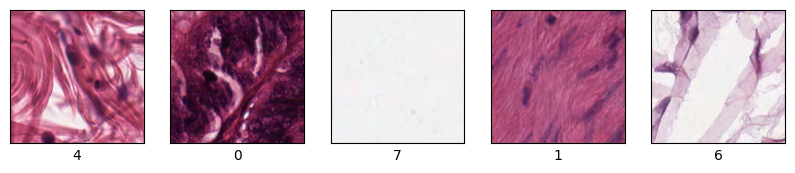

In [5]:
plt.figure(figsize=(10,10))
i = 0

for image, label in dataset.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((150, 150, 3)))
    plt.xlabel(label.numpy())

    i = i + 1

In [6]:
def calc_means(old, new):
  img, _ = new
  old += tf.reduce_mean(tf.cast(img, tf.float32), (0, 1))
  return old

def calc_vars(old, new):
  img, _ = new
  old += tf.math.reduce_variance(tf.cast(img, tf.float32), (0, 1))
  return old

In [7]:
means = dataset.reduce([0., 0., 0.], calc_means)/tf.cast(dataset.cardinality(),tf.float32)
vars = dataset.reduce([0., 0., 0.], calc_vars)/tf.cast(dataset.cardinality(),tf.float32)
print(means)
print(vars)


tf.Tensor([165.72412 120.4448  149.02147], shape=(3,), dtype=float32)
tf.Tensor([1630.6935 1759.9424 1336.2097], shape=(3,), dtype=float32)


In [8]:
# Normalize dataset, mean = 0, var = 1
dataset_norm = dataset.map(lambda img, lbl: (layers.Normalization(axis=-1, mean=means, variance=vars)(tf.cast(img, tf.float32)), lbl))

means_norm = dataset_norm.reduce([0., 0., 0.], calc_means)/tf.cast(dataset_norm.cardinality(),tf.float32)
vars_norm = dataset_norm.reduce([0., 0., 0.], calc_vars)/tf.cast(dataset_norm.cardinality(),tf.float32)
print(means_norm)
print(vars_norm)


tf.Tensor([1.9030094e-06 2.0935058e-06 3.6531926e-06], shape=(3,), dtype=float32)
tf.Tensor([1.0000004  0.99999905 1.0000002 ], shape=(3,), dtype=float32)


In [9]:
print(dataset)
print(dataset_norm)

<_ShuffleDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


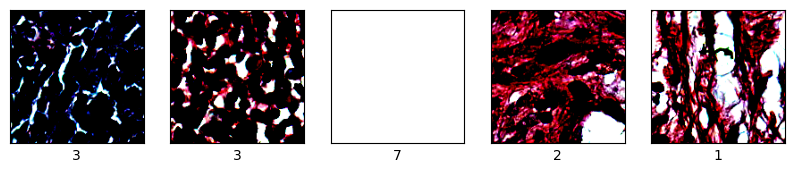

In [10]:

plt.figure(figsize=(10,10))
i = 0

for image, label in dataset_norm.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((150, 150, 3)))
    plt.xlabel(label.numpy())

    i = i + 1

In [11]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
])

In [12]:
batch_size = 64
valid_data = dataset_norm.take(1000)
valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data       = dataset_norm.skip(1000).take(1000)
test_data       = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data   = dataset_norm.skip(2000).take(3000)
train_data   = train_data.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

train_data = train_data.map(
    lambda img, label: (data_augmentation(img, training=True), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)


train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
print(train_data)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [14]:
def train_model(model, epochs = 25):
  earlystop = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=30,
                                               restore_best_weights=False)
  model_file = checkpoints_dir+model.name + '.weights.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file,
                    monitor="val_accuracy", mode="max",
                    save_weights_only=True,
                    save_best_only=True, verbose=1)

  return model.fit(train_data, validation_data=valid_data, epochs=epochs,
                   callbacks = [earlystop, checkpoint], verbose = 1)

def compile_model(model, lr = 2e-4, summary= True):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy'])
  if (summary):
        print(model.summary())
  return model

def benchmark(model, hist):
  error = [1 - acc for acc in hist.history["accuracy"]]
  val_error = [1 - val_acc for val_acc in hist.history["val_accuracy"]]

  plt.plot(error)
  plt.plot(val_error)
  plt.title("model Error")
  plt.ylabel("Error")
  plt.xlabel("Epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.grid(True)
  plt.title(model.name)
  plt.show()

  test_loss, test_acc = model.evaluate(test_data)
  test_err = 1-test_acc
  print(f'Test Error:{test_err * 100:.2f}%')
  return test_err

In [93]:
def layerNormalization(x, normalization, groups = 16):
  if (normalization == "batch"):
    return layers.BatchNormalization()(x)
  if (normalization == "layer"):
    return layers.LayerNormalization()(x)
  if (normalization == "group"):
    return layers.GroupNormalization(groups = groups)(x)
    return x

def layerDropout(x, dropout, rate = 0.1):
  if (dropout == "dropout"):
    return layers.Dropout(rate)(x)
  if (dropout == "spatial"):
    return layers.SpatialDropout2D(rate)(x)
  return x


def create_model(model_name, dropout="dropout", activation="relu",
                 use_resblock=False, normalization="batch", dilation_rate=1):
  possible_dropouts = (None, "dropout", "spatial")
  possible_activations = ("relu", "selu", "swish")
  possible_normalizations= (None, "batch", "layer", "group")

  residual = None
  input = layers.Input(shape=(150, 150, 3))
  x = input

  x = layers.Conv2D(filters = 16, kernel_size = 3, strides=2, padding="same", dilation_rate = 1)(x)
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)
  x = layers.MaxPool2D(pool_size=2,padding="same")(x)

  if (use_resblock==True):
    residual = x

  x = layers.Conv2D(filters = 16, kernel_size = 3, strides=1, padding="same", dilation_rate = dilation_rate)(x)
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)

  #x = layerDropout(x, dropout, rate = 0.1)

  x = layers.Conv2D(filters = 16, kernel_size = 3, strides=1, padding="same", dilation_rate = dilation_rate)(x)

  if (use_resblock==True):
    residual = layers.Conv2D(filters = 16, kernel_size = 1, strides=1, padding="same")(
       residual
    )
    x = layers.add([x, residual])
    residual = x
  
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)
  x = layers.Conv2D(filters = 32, kernel_size = 3, strides=2, padding="same", dilation_rate = 1)(x)
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)

  #x = layerDropout(x, dropout, rate = 0.1)
  x = layers.Conv2D(filters = 32, kernel_size = 3, strides=1, padding="same", dilation_rate = dilation_rate)(x)
  
  if (use_resblock==True):
    residual = layers.Conv2D(filters = 32, kernel_size = 1, strides=2, padding="same")(
       residual
    )
    x = layers.add([x, residual])
    residual = x

  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)
  x = layers.Conv2D(filters = 32, kernel_size = 3, strides=1, padding="same", dilation_rate = 1)(x)
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)

  x = layerDropout(x, dropout, rate = 0.1)
  x = layers.Conv2D(filters = 32, kernel_size = 3, strides=1, padding="same", dilation_rate = dilation_rate)(x)

  if (use_resblock==True):
    residual = layers.Conv2D(filters = 32, kernel_size = 1, strides=1, padding="same")(
       residual
    )
    x = layers.add([x, residual])
    residual = x
    
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)
  x = layers.Conv2D(filters = 64, kernel_size = 3, strides=2, padding="same", dilation_rate = 1)(x)
  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)

  x = layerDropout(x, dropout, rate = 0.25)

  x = layers.Conv2D(filters = 64, kernel_size = 3, strides=1, padding="same", dilation_rate = dilation_rate)(x)

  if (use_resblock==True):
    residual = layers.Conv2D(filters = 64, kernel_size = 1, strides=2, padding="same")(
       residual
    )
    x = layers.add([x, residual])
    residual = x

  x = layerNormalization(x, normalization)
  x = layers.Activation(activation)(x)
    
  #x = layerDropout(x, dropout, rate = 0.1)

  #x = layers.GlobalMaxPooling2D()(x)
  x = layers.GlobalAveragePooling2D()(x)
  #x = layers.AveragePooling2D()(x)

  x = layers.Flatten()(x)

  out = layers.Dense(8, activation=tf.keras.activations.softmax)(x)

  return Model(inputs=input, outputs=out, name=model_name)

In [94]:
# test normalizations
model_batch = create_model('relu_batch_dilation_1',
        dropout = None, activation='relu', use_resblock=False,
        normalization='batch', dilation_rate=1)


In [95]:


model_layer = create_model('relu_layer_dilation_1',
        dropout = None, activation='relu', use_resblock=False,
        normalization='layer', dilation_rate=1)

model_group = create_model('relu_group_dilation_1',
        dropout = None, activation='relu', use_resblock=False,
        normalization='group', dilation_rate=1)



In [96]:
scores = {'Model':[], 'test Error': []}

In [97]:
model = model_batch
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "relu_batch_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_250 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 batch_normalization_174 (B  (None, 75, 75, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_208 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                             

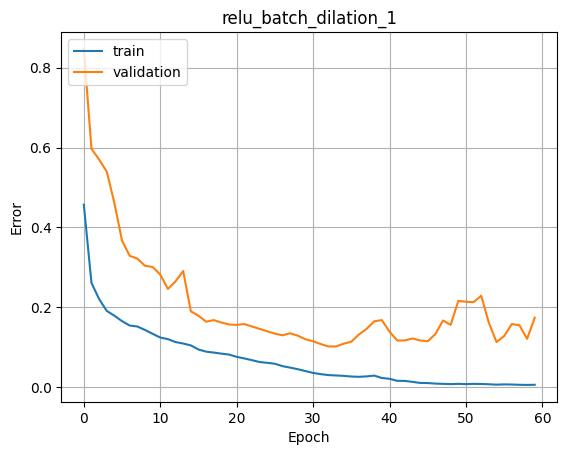

16/16 [==============================] - 0s 11ms/step - loss: 0.3329 - accuracy: 0.8850
Test Error:11.50%


In [98]:
model = model_batch
error = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(error)

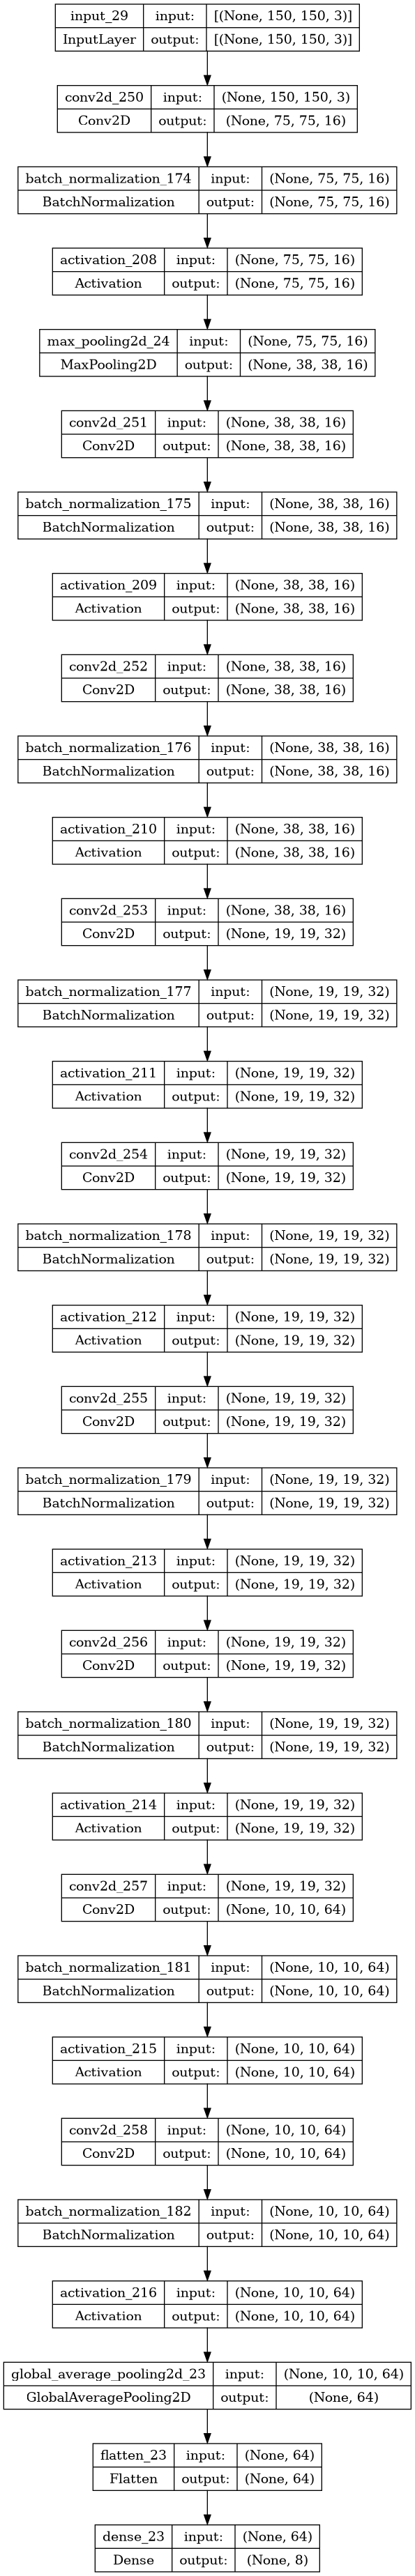

In [99]:
keras.utils.plot_model(model, show_shapes=True)

In [100]:
 val_loss, val_acc= model.evaluate(valid_data)
 print(val_loss, val_acc)

16/16 [==============================] - 0s 10ms/step - loss: 0.3189 - accuracy: 0.8980
0.31891894340515137 0.8980000019073486


In [101]:
model = model_layer
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)


Model: "relu_layer_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_259 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 layer_normalization_27 (La  (None, 75, 75, 16)        32        
 yerNormalization)                                               
                                                                 
 activation_217 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                             

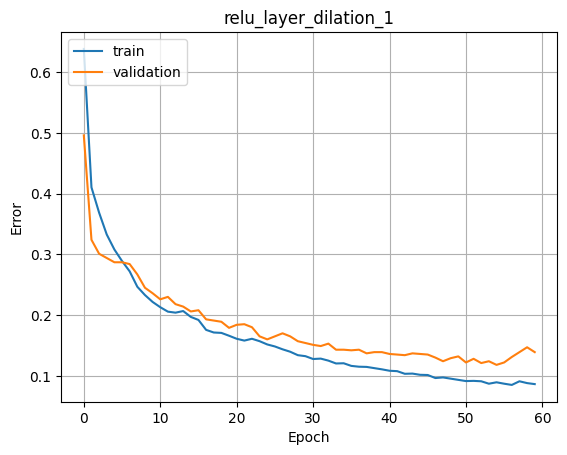

16/16 [==============================] - 1s 33ms/step - loss: 0.3604 - accuracy: 0.8870
Test Error:11.30%


In [102]:
model = model_layer
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [103]:
model = model_group
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "relu_group_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_268 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 group_normalization_12 (Gr  (None, 75, 75, 16)        32        
 oupNormalization)                                               
                                                                 
 activation_226 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                             

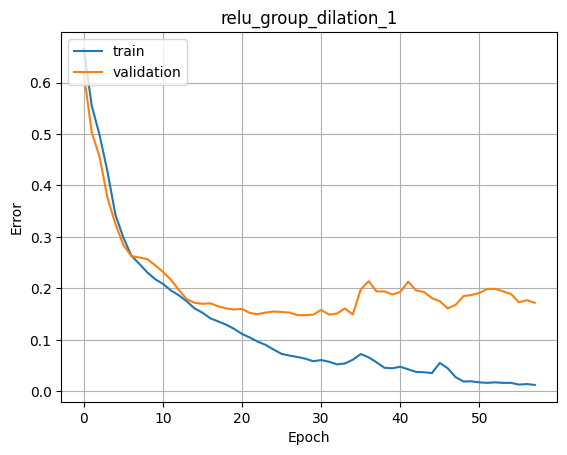

16/16 [==============================] - 0s 14ms/step - loss: 0.5003 - accuracy: 0.8230
Test Error:17.70%


In [104]:
model = model_group
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [105]:
# test activation functions
model_selu = create_model('selu_batch_dilation_1',
        dropout = None, activation='selu', use_resblock=False,
        normalization='batch', dilation_rate=1)

model_swish = create_model('swish_batch_dilation_1',
        dropout = None, activation='swish', use_resblock=False,
        normalization='batch', dilation_rate=1)

In [106]:
model = model_selu
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "selu_batch_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_277 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 batch_normalization_183 (B  (None, 75, 75, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_235 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                             

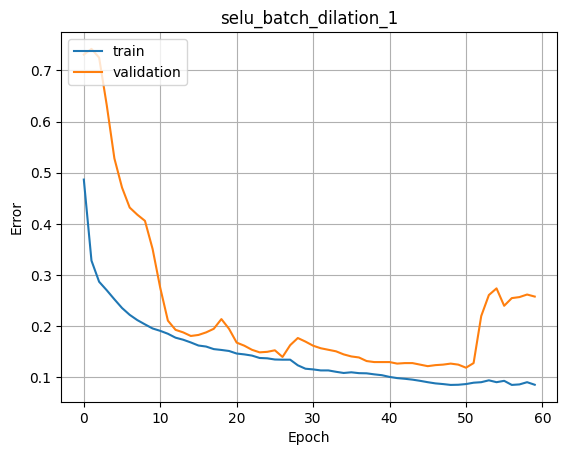

16/16 [==============================] - 0s 11ms/step - loss: 0.4172 - accuracy: 0.8590
Test Error:14.10%


In [107]:
model = model_selu
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [108]:
model = model_swish
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "swish_batch_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_286 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 batch_normalization_192 (B  (None, 75, 75, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_244 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                            

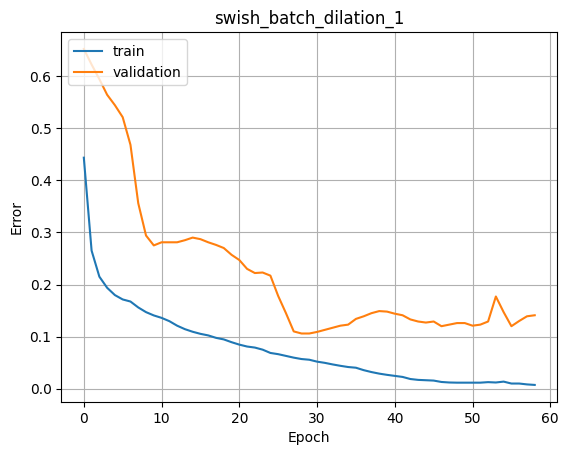

16/16 [==============================] - 0s 12ms/step - loss: 0.3604 - accuracy: 0.8800
Test Error:12.00%


In [109]:
model = model_swish
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [110]:

# test dropouts
model_drop = create_model('Dropout_relu_batch_dilation_1',
        dropout = 'dropout', activation='relu', use_resblock=False,
        normalization='batch', dilation_rate=1)




In [111]:

model_spatial = create_model('Spatial_relu_batch_dilation_1',
        dropout = 'spatial', activation='relu', use_resblock=False,
        normalization='batch', dilation_rate=1)

In [112]:
model = model_drop
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "Dropout_relu_batch_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_295 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 batch_normalization_201 (B  (None, 75, 75, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_253 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                     

2023-12-13 05:37:14.875671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDropout_relu_batch_dilation_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/47 [============================>.] - ETA: 0s - loss: 1.4449 - accuracy: 0.4575
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to colorectal_histology/checkpoints/Dropout_relu_batch_dilation_1.weights.h5
47/47 [==============================] - 8s 39ms/step - loss: 1.4354 - accuracy: 0.4633 - val_loss: 2.0089 - val_accuracy: 0.2500
Epoch 2/60
46/47 [============================>.] - ETA: 0s - loss: 0.8563 - accuracy: 0.7435
Epoch 2: val_accuracy improved from 0.25000 to 0.25100, saving model to colorectal_histology/checkpoints/Dropout_relu_batch_dilation_1.weights.h5
47/47 [==============================] - 1s 32ms/step - loss: 0.8529 - accuracy: 0.7437 - val_loss: 1.9513 - val_accuracy: 0.2510
Epoch 3/60
45/47 [===========================>..] - ETA: 0s - loss: 0.7075 - accuracy: 0.7628
Epoch 3: val_accuracy improved from 0.25100 to 0.26300, saving model to colorectal_histology/checkpoints/Dropout_relu_batch_dilation_1.weights.h5
47/47 [===========================

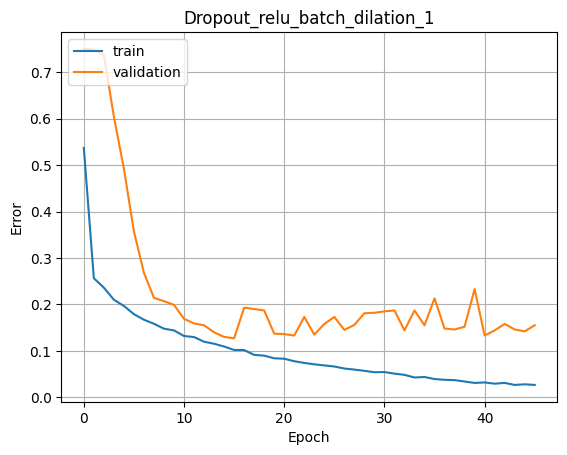

16/16 [==============================] - 0s 10ms/step - loss: 0.3970 - accuracy: 0.8710
Test Error:12.90%


In [113]:
model = model_drop
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [114]:
model = model_spatial
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "Spatial_relu_batch_dilation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_304 (Conv2D)         (None, 75, 75, 16)        448       
                                                                 
 batch_normalization_210 (B  (None, 75, 75, 16)        64        
 atchNormalization)                                              
                                                                 
 activation_262 (Activation  (None, 75, 75, 16)        0         
 )                                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                           
                                     

2023-12-13 05:38:27.061958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSpatial_relu_batch_dilation_1/spatial_dropout2d_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/47 [============================>.] - ETA: 0s - loss: 1.5529 - accuracy: 0.4052
Epoch 1: val_accuracy improved from -inf to 0.39100, saving model to colorectal_histology/checkpoints/Spatial_relu_batch_dilation_1.weights.h5
47/47 [==============================] - 8s 39ms/step - loss: 1.5440 - accuracy: 0.4100 - val_loss: 1.8547 - val_accuracy: 0.3910
Epoch 2/60
46/47 [============================>.] - ETA: 0s - loss: 1.0666 - accuracy: 0.6362
Epoch 2: val_accuracy improved from 0.39100 to 0.52700, saving model to colorectal_histology/checkpoints/Spatial_relu_batch_dilation_1.weights.h5
47/47 [==============================] - 2s 33ms/step - loss: 1.0628 - accuracy: 0.6390 - val_loss: 1.4518 - val_accuracy: 0.5270
Epoch 3/60
46/47 [============================>.] - ETA: 0s - loss: 0.9236 - accuracy: 0.6885
Epoch 3: val_accuracy improved from 0.52700 to 0.62300, saving model to colorectal_histology/checkpoints/Spatial_relu_batch_dilation_1.weights.h5
47/47 [===========================

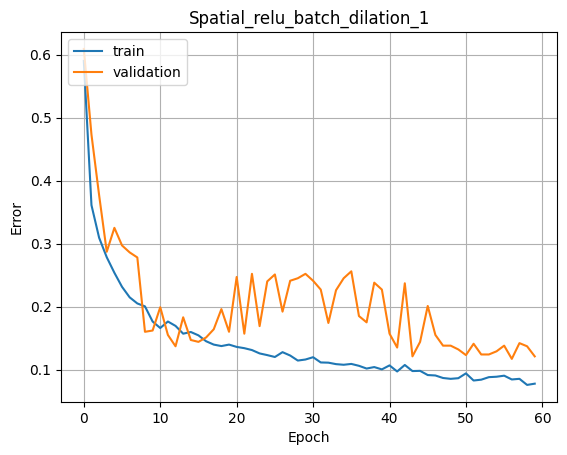

16/16 [==============================] - 0s 11ms/step - loss: 0.3286 - accuracy: 0.8790
Test Error:12.10%


In [115]:
model = model_spatial
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

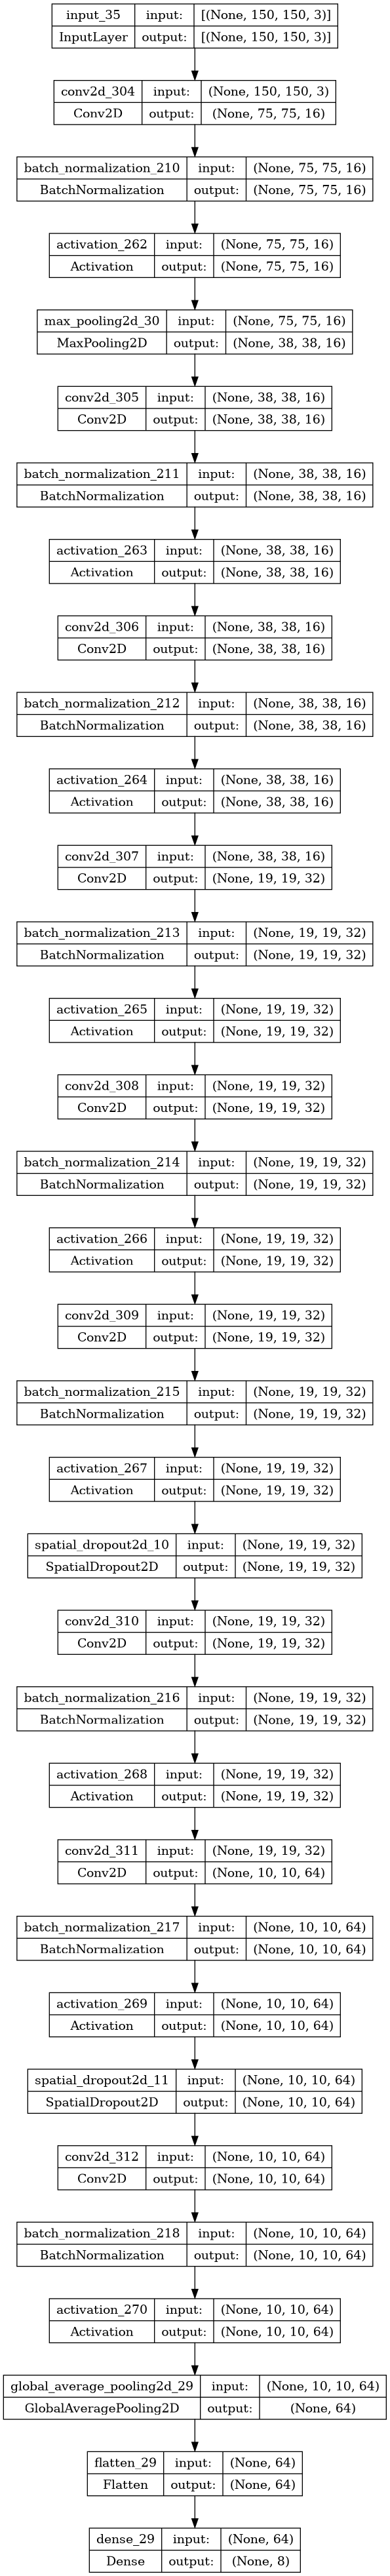

In [116]:
keras.utils.plot_model(model, show_shapes=True)

In [117]:

# test residual
model_res_spatial = create_model('Spatial_relu_resid_batch_dilation_1',
        dropout = 'spatial', activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=1)
model_res = create_model('relu_resid_batch_dilation_1',
        dropout = None, activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=1)

model_res_drop = create_model('Dropout_relu_resid_batch_dilation_1',
        dropout = "dropout", activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=1)

In [118]:
model = model_res_spatial
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "Spatial_relu_resid_batch_dilation_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_313 (Conv2D)         (None, 75, 75, 16)           448       ['input_36[0][0]']            
                                                                                                  
 batch_normalization_219 (B  (None, 75, 75, 16)           64        ['conv2d_313[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_271 (Activation  (None, 75, 75, 16)           0     

2023-12-13 05:40:00.296687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSpatial_relu_resid_batch_dilation_1/spatial_dropout2d_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - ETA: 0s - loss: 1.4411 - accuracy: 0.4777
Epoch 1: val_accuracy improved from -inf to 0.31500, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_1.weights.h5
47/47 [==============================] - 9s 43ms/step - loss: 1.4411 - accuracy: 0.4777 - val_loss: 1.8251 - val_accuracy: 0.3150
Epoch 2/60
45/47 [===========================>..] - ETA: 0s - loss: 0.9936 - accuracy: 0.6847
Epoch 2: val_accuracy improved from 0.31500 to 0.42100, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_1.weights.h5
47/47 [==============================] - 2s 35ms/step - loss: 0.9869 - accuracy: 0.6877 - val_loss: 1.4368 - val_accuracy: 0.4210
Epoch 3/60
45/47 [===========================>..] - ETA: 0s - loss: 0.8558 - accuracy: 0.7031
Epoch 3: val_accuracy improved from 0.42100 to 0.56500, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_1.weights.h5
47/47 [=========

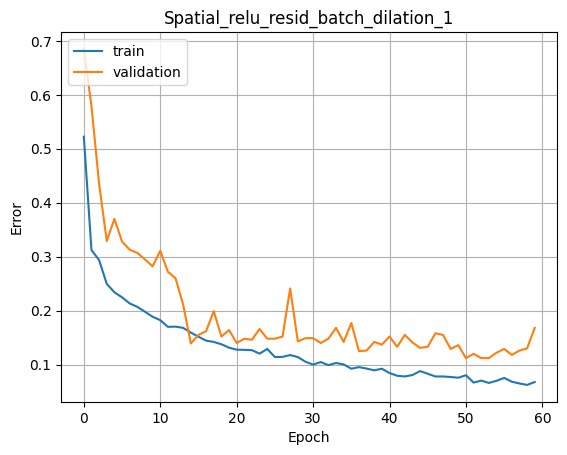

16/16 [==============================] - 0s 11ms/step - loss: 0.3122 - accuracy: 0.8740
Test Error:12.60%


In [119]:
model = model_res_spatial
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

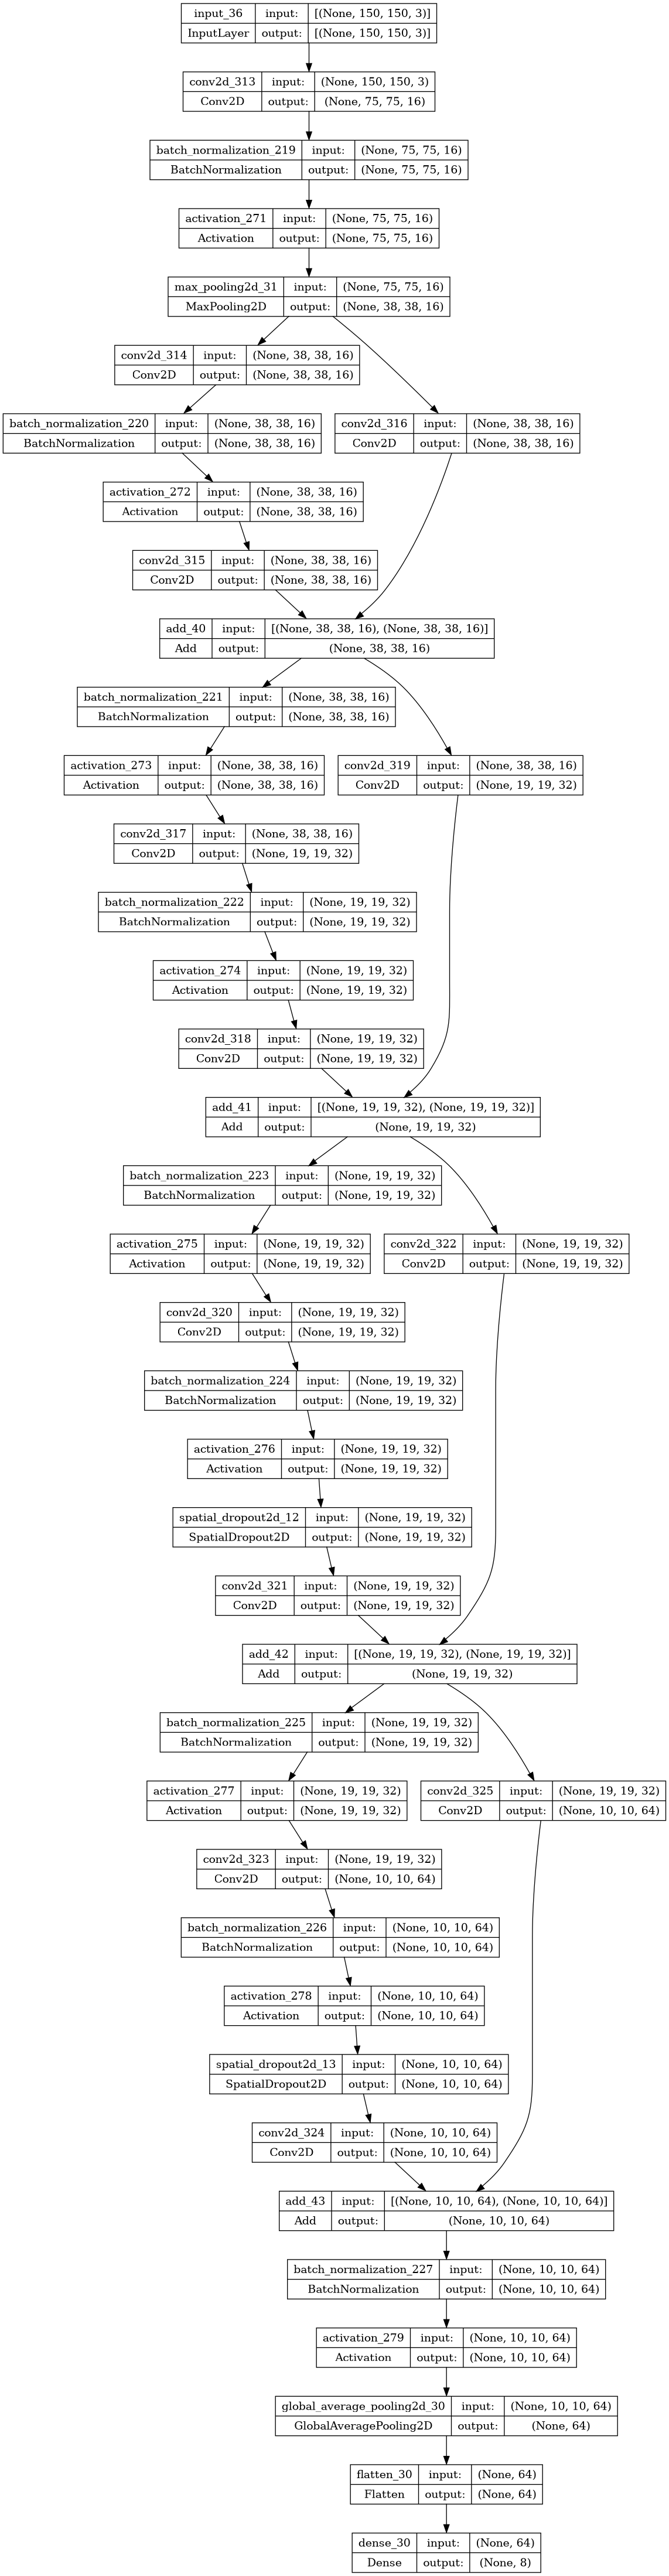

In [120]:
keras.utils.plot_model(model, show_shapes=True)

In [121]:
model = model_res_drop
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "Dropout_relu_resid_batch_dilation_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_339 (Conv2D)         (None, 75, 75, 16)           448       ['input_38[0][0]']            
                                                                                                  
 batch_normalization_237 (B  (None, 75, 75, 16)           64        ['conv2d_339[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_289 (Activation  (None, 75, 75, 16)           0     

2023-12-13 05:41:39.564911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDropout_relu_resid_batch_dilation_1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/47 [===========================>..] - ETA: 0s - loss: 1.4209 - accuracy: 0.4882
Epoch 1: val_accuracy improved from -inf to 0.30100, saving model to colorectal_histology/checkpoints/Dropout_relu_resid_batch_dilation_1.weights.h5
47/47 [==============================] - 9s 44ms/step - loss: 1.4054 - accuracy: 0.4977 - val_loss: 1.6047 - val_accuracy: 0.3010
Epoch 2/60
45/47 [===========================>..] - ETA: 0s - loss: 0.9168 - accuracy: 0.7135
Epoch 2: val_accuracy improved from 0.30100 to 0.41300, saving model to colorectal_histology/checkpoints/Dropout_relu_resid_batch_dilation_1.weights.h5
47/47 [==============================] - 2s 36ms/step - loss: 0.9123 - accuracy: 0.7177 - val_loss: 1.4899 - val_accuracy: 0.4130
Epoch 3/60
45/47 [===========================>..] - ETA: 0s - loss: 0.7472 - accuracy: 0.7646
Epoch 3: val_accuracy improved from 0.41300 to 0.48100, saving model to colorectal_histology/checkpoints/Dropout_relu_resid_batch_dilation_1.weights.h5
47/47 [=========

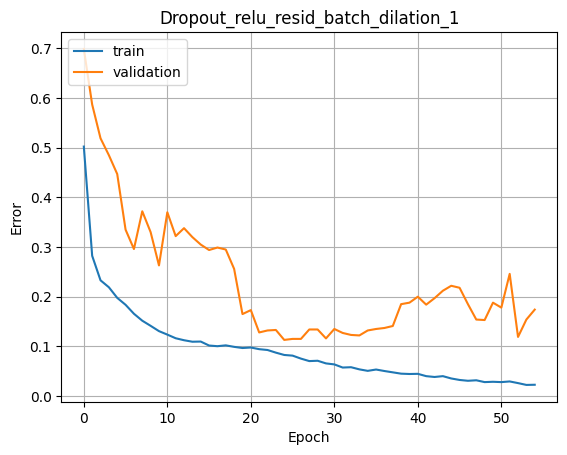

16/16 [==============================] - 0s 11ms/step - loss: 0.3744 - accuracy: 0.8680
Test Error:13.20%


In [122]:
model = model_res_drop
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [123]:
model = model_res
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "relu_resid_batch_dilation_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_326 (Conv2D)         (None, 75, 75, 16)           448       ['input_37[0][0]']            
                                                                                                  
 batch_normalization_228 (B  (None, 75, 75, 16)           64        ['conv2d_326[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_280 (Activation  (None, 75, 75, 16)           0         ['ba

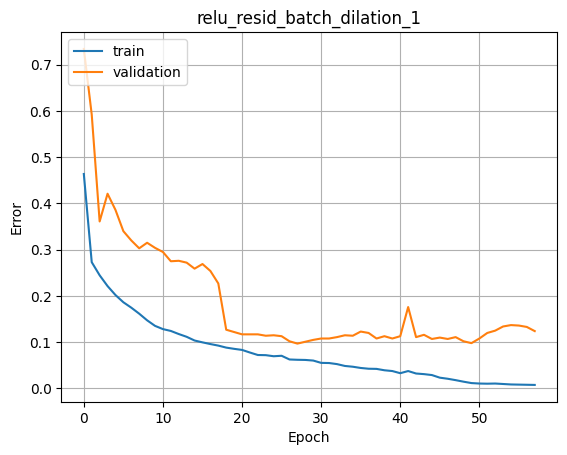

16/16 [==============================] - 0s 11ms/step - loss: 0.3266 - accuracy: 0.8840
Test Error:11.60%


In [124]:
model = model_res
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [125]:
val_loss, val_acc= model_res.evaluate(valid_data)
print(val_loss, val_acc)

16/16 [==============================] - 0s 11ms/step - loss: 0.3052 - accuracy: 0.9030
0.3051709532737732 0.902999997138977


In [126]:

# test dilation
model_dil2_spatial =  create_model('Spatial_relu_resid_batch_dilation_2',
        dropout = 'spatial', activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=2)
model_dil3_spatial =  create_model('Spatial_relu_resid_batch_dilation_3',
        dropout = 'spatial', activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=3)

model_dil2 = create_model('relu_resid_batch_dilation_2',
        dropout = None, activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=2)

model_dil3 = create_model('relu_resid_batch_dilation_3',
        dropout = None, activation='relu', use_resblock=True,
        normalization='batch', dilation_rate=3)

In [127]:
model = model_dil2
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "relu_resid_batch_dilation_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_378 (Conv2D)         (None, 75, 75, 16)           448       ['input_41[0][0]']            
                                                                                                  
 batch_normalization_264 (B  (None, 75, 75, 16)           64        ['conv2d_378[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_316 (Activation  (None, 75, 75, 16)           0         ['ba

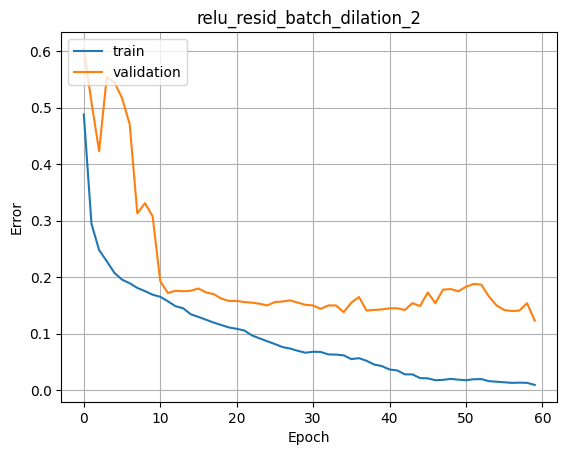

16/16 [==============================] - 0s 12ms/step - loss: 0.3949 - accuracy: 0.8870
Test Error:11.30%


In [128]:
model = model_dil2
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [129]:
model = model_dil3
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "relu_resid_batch_dilation_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_391 (Conv2D)         (None, 75, 75, 16)           448       ['input_42[0][0]']            
                                                                                                  
 batch_normalization_273 (B  (None, 75, 75, 16)           64        ['conv2d_391[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_325 (Activation  (None, 75, 75, 16)           0         ['ba

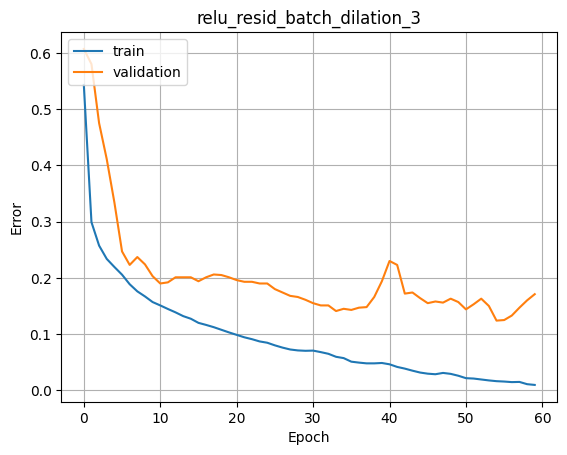

16/16 [==============================] - 0s 14ms/step - loss: 0.3997 - accuracy: 0.8680
Test Error:13.20%


In [130]:
model = model_dil3
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [131]:
model = model_dil2_spatial
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "Spatial_relu_resid_batch_dilation_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_352 (Conv2D)         (None, 75, 75, 16)           448       ['input_39[0][0]']            
                                                                                                  
 batch_normalization_246 (B  (None, 75, 75, 16)           64        ['conv2d_352[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_298 (Activation  (None, 75, 75, 16)           0     

2023-12-13 05:47:50.769859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSpatial_relu_resid_batch_dilation_2/spatial_dropout2d_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - ETA: 0s - loss: 1.5364 - accuracy: 0.4153
Epoch 1: val_accuracy improved from -inf to 0.13200, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_2.weights.h5
47/47 [==============================] - 10s 46ms/step - loss: 1.5364 - accuracy: 0.4153 - val_loss: 2.0825 - val_accuracy: 0.1320
Epoch 2/60
47/47 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.6203
Epoch 2: val_accuracy improved from 0.13200 to 0.37200, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_2.weights.h5
47/47 [==============================] - 2s 37ms/step - loss: 1.0453 - accuracy: 0.6203 - val_loss: 1.4692 - val_accuracy: 0.3720
Epoch 3/60
47/47 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.7070
Epoch 3: val_accuracy improved from 0.37200 to 0.46800, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_2.weights.h5
47/47 [========

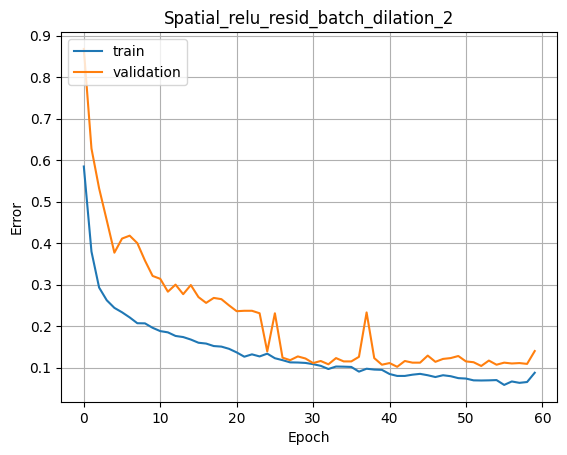

16/16 [==============================] - 0s 13ms/step - loss: 0.3248 - accuracy: 0.8880
Test Error:11.20%


In [132]:
model = model_dil2_spatial
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [133]:
model = model_dil3_spatial
compile_model(model)
hist = train_model(model, 60)
model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)

Model: "Spatial_relu_resid_batch_dilation_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_365 (Conv2D)         (None, 75, 75, 16)           448       ['input_40[0][0]']            
                                                                                                  
 batch_normalization_255 (B  (None, 75, 75, 16)           64        ['conv2d_365[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_307 (Activation  (None, 75, 75, 16)           0     

2023-12-13 05:49:36.990989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSpatial_relu_resid_batch_dilation_3/spatial_dropout2d_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - ETA: 0s - loss: 1.6502 - accuracy: 0.3970
Epoch 1: val_accuracy improved from -inf to 0.26200, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_3.weights.h5
47/47 [==============================] - 10s 47ms/step - loss: 1.6502 - accuracy: 0.3970 - val_loss: 1.8283 - val_accuracy: 0.2620
Epoch 2/60
47/47 [==============================] - ETA: 0s - loss: 1.0643 - accuracy: 0.6573
Epoch 2: val_accuracy improved from 0.26200 to 0.40700, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_3.weights.h5
47/47 [==============================] - 2s 37ms/step - loss: 1.0643 - accuracy: 0.6573 - val_loss: 1.6793 - val_accuracy: 0.4070
Epoch 3/60
47/47 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.7033
Epoch 3: val_accuracy improved from 0.40700 to 0.47600, saving model to colorectal_histology/checkpoints/Spatial_relu_resid_batch_dilation_3.weights.h5
47/47 [========

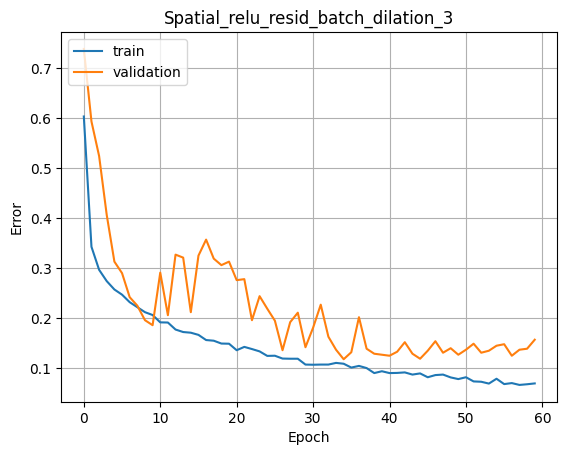

16/16 [==============================] - 0s 13ms/step - loss: 0.3477 - accuracy: 0.8660
Test Error:13.40%


In [134]:
model = model_dil3_spatial
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [135]:
def build_for_transfer(base, num_classes, name):
    inputs = layers.Input(shape=(150, 150, 3))
    base_model = base(include_top=False, input_tensor=inputs, weights="imagenet")
    x = inputs
    # Freeze the pretrained weights
    base_model.trainable = False
    
    # Rebuild top
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = Model(inputs, outputs, name=name)
    compile_model(model, lr = 1e-2, summary=False)
    return model


In [136]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    compile_model(model, lr = 1e-5, summary=False)




In [67]:
# transfer learning EfficientNet
base_model = keras.applications.EfficientNetB0
model_effnet = build_for_transfer(base_model, num_classes=8, name = "EfficientNet")
model = model_effnet
epochs = 25
hist = train_model(model, epochs)

model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)



Epoch 1/25
47/47 [==============================] - ETA: 0s - loss: 1.5141 - accuracy: 0.5600
Epoch 1: val_accuracy improved from -inf to 0.24400, saving model to colorectal_histology/checkpoints/EfficientNet.weights.h5
47/47 [==============================] - 15s 156ms/step - loss: 1.5141 - accuracy: 0.5600 - val_loss: 2.2118 - val_accuracy: 0.2440
Epoch 2/25
47/47 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.6893
Epoch 2: val_accuracy improved from 0.24400 to 0.27200, saving model to colorectal_histology/checkpoints/EfficientNet.weights.h5
47/47 [==============================] - 5s 102ms/step - loss: 0.9589 - accuracy: 0.6893 - val_loss: 2.1979 - val_accuracy: 0.2720
Epoch 3/25
47/47 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.7063
Epoch 3: val_accuracy improved from 0.27200 to 0.32900, saving model to colorectal_histology/checkpoints/EfficientNet.weights.h5
47/47 [==============================] - 5s 102ms/step - loss: 0.8710 -

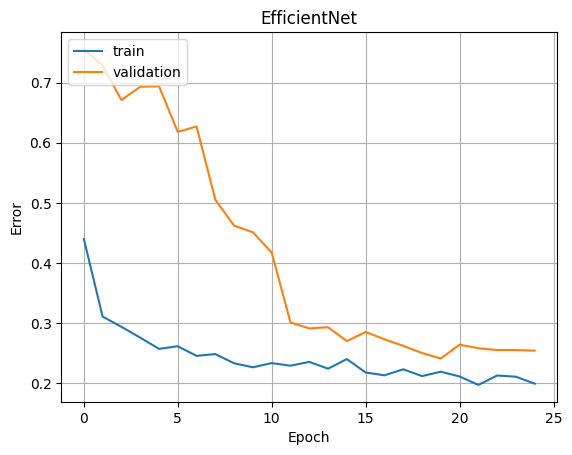

16/16 [==============================] - 1s 60ms/step - loss: 0.7568 - accuracy: 0.7710
Test Error:22.90%


In [68]:
model = model_effnet
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

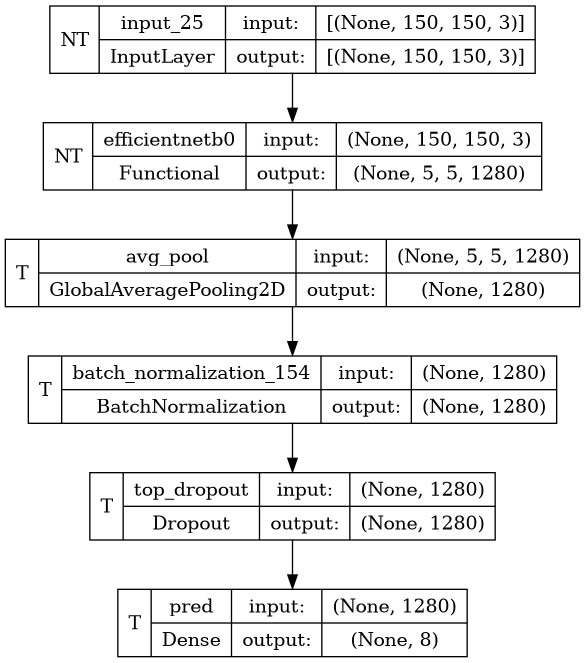

In [69]:
keras.utils.plot_model(model, show_shapes=True, show_trainable=True)

In [137]:
# finetuning EfficientNet
model = model_effnet
unfreeze_model(model)
model._name = model.name + "_finetuned"
epochs = 8
hist = train_model(model, epochs)

Epoch 1/8
47/47 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8437
Epoch 1: val_accuracy improved from -inf to 0.79100, saving model to colorectal_histology/checkpoints/EfficientNet_finetuned_finetuned.weights.h5
47/47 [==============================] - 53s 340ms/step - loss: 0.4134 - accuracy: 0.8437 - val_loss: 0.7280 - val_accuracy: 0.7910
Epoch 2/8
47/47 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8580
Epoch 2: val_accuracy improved from 0.79100 to 0.80600, saving model to colorectal_histology/checkpoints/EfficientNet_finetuned_finetuned.weights.h5
47/47 [==============================] - 15s 311ms/step - loss: 0.3650 - accuracy: 0.8580 - val_loss: 0.6885 - val_accuracy: 0.8060
Epoch 3/8
47/47 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.8717
Epoch 3: val_accuracy improved from 0.80600 to 0.81500, saving model to colorectal_histology/checkpoints/EfficientNet_finetuned_finetuned.weights.h5
47/47 [======

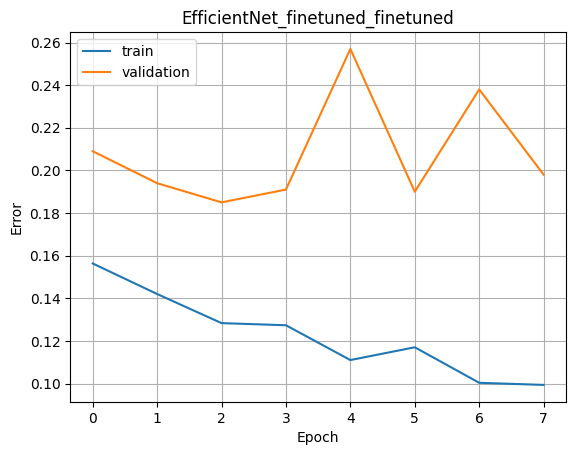

16/16 [==============================] - 1s 61ms/step - loss: 0.6722 - accuracy: 0.8030
Test Error:19.70%


In [138]:
model = model_effnet
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

In [72]:
# transfer learning MobileNetV2
base_model = keras.applications.MobileNetV2
model_mobnet = build_for_transfer(base_model, num_classes=8, name = "MobileNetV2")
model = model_mobnet
epochs = 25
hist = train_model(model, epochs)

model_file = checkpoints_dir+model.name + '.weights.h5'
model.load_weights(model_file)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/25
47/47 [==============================] - ETA: 0s - loss: 1.0197 - accuracy: 0.7587
Epoch 1: val_accuracy improved from -inf to 0.71700, saving model to colorectal_histology/checkpoints/MobileNetV2.weights.h5
47/47 [==============================] - 8s 103ms/step - loss: 1.0197 - accuracy: 0.7587 - val_loss: 1.2107 - val_accuracy: 0.7170
Epoch 2/25
47/47 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8723
Epoch 2: val_accuracy improved from 0.71700 to 0.79600, saving model to colorectal_histology/checkpoints/MobileNetV2.weights.h5
47/47 [==============================] - 3s 70ms/step - loss: 0.5098 - accuracy: 0.8723 - val_loss: 0.8040 - val_accuracy: 0.7960
Epoch 3/25
47/47 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8993
Epoch 3: val_accuracy improved from 0.79600 to 0.83300, saving model to colorectal_histology/checkpoints/MobileNetV2.weights.h5
47/47 [======

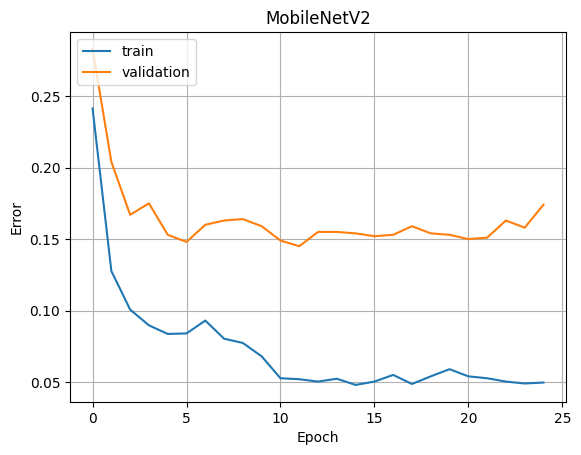

16/16 [==============================] - 1s 42ms/step - loss: 0.9218 - accuracy: 0.8410
Test Error:15.90%


In [73]:
model = model_mobnet
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

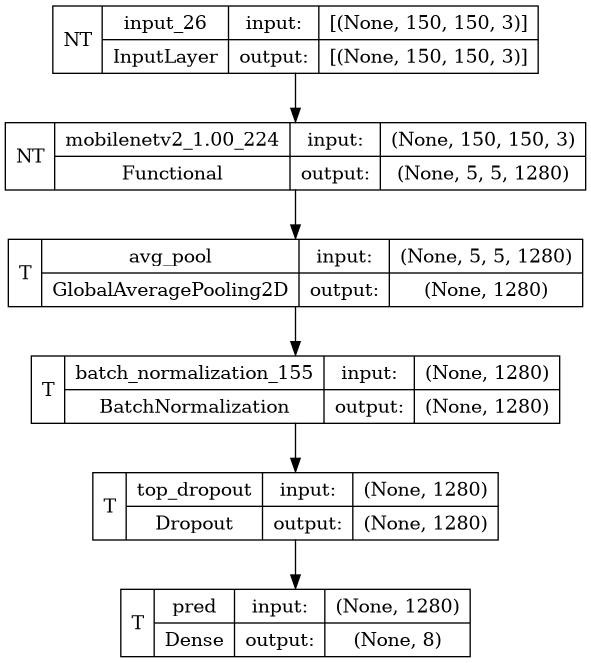

In [74]:
keras.utils.plot_model(model, show_shapes=True, show_trainable=True)

In [139]:
# finetuning MobileNetV2
model = model_mobnet
unfreeze_model(model)

model._name = model.name + "_finetuned"
epochs = 8
hist = train_model(model, epochs)

Epoch 1/8
47/47 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9713
Epoch 1: val_accuracy improved from -inf to 0.85800, saving model to colorectal_histology/checkpoints/MobileNetV2_finetuned_finetuned.weights.h5
47/47 [==============================] - 35s 194ms/step - loss: 0.0844 - accuracy: 0.9713 - val_loss: 0.9130 - val_accuracy: 0.8580
Epoch 2/8
47/47 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9830
Epoch 2: val_accuracy improved from 0.85800 to 0.87300, saving model to colorectal_histology/checkpoints/MobileNetV2_finetuned_finetuned.weights.h5
47/47 [==============================] - 8s 175ms/step - loss: 0.0528 - accuracy: 0.9830 - val_loss: 0.8934 - val_accuracy: 0.8730
Epoch 3/8
47/47 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9853
Epoch 3: val_accuracy did not improve from 0.87300
47/47 [==============================] - 7s 158ms/step - loss: 0.0481 - accuracy: 0.9853 - val_loss: 0.7824 - val_

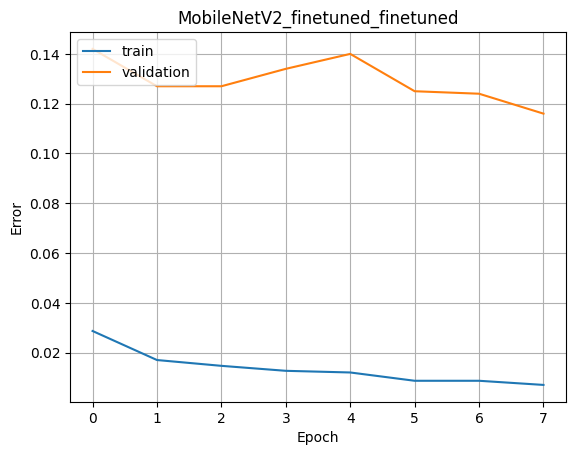

16/16 [==============================] - 1s 40ms/step - loss: 0.7582 - accuracy: 0.8780
Test Error:12.20%


In [140]:
model = model_mobnet
accuracy = benchmark(model, hist)
scores['Model'].append(model.name)
scores['test Error'].append(accuracy)

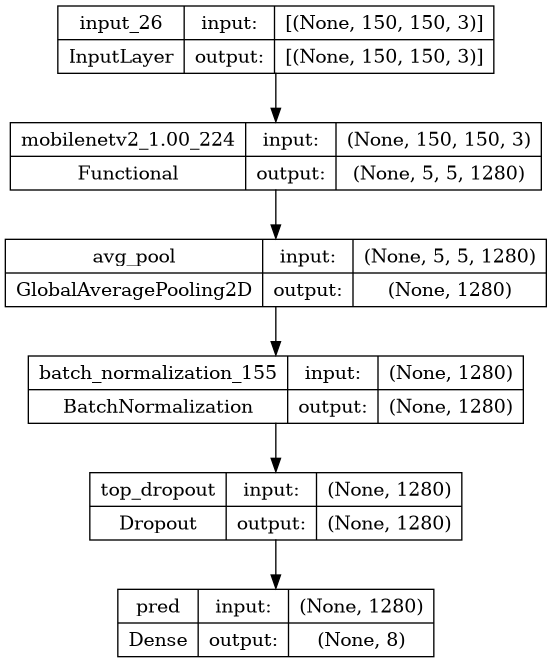

In [77]:
keras.utils.plot_model(model, show_shapes=True)

In [141]:


display(pd.DataFrame(scores))


,Model,test Error
0,relu_batch_dilation_1,0.115
1,relu_layer_dilation_1,0.113
2,relu_group_dilation_1,0.177
3,selu_batch_dilation_1,0.141
4,swish_batch_dilation_1,0.120
5,Dropout_relu_batch_dilation_1,0.129
6,Spatial_relu_batch_dilation_1,0.121
7,Spatial_relu_resid_batch_dilation_1,0.126
8,Dropout_relu_resid_batch_dilation_1,0.132
9,relu_resid_batch_dilation_1,0.116
